*Copyright (c) Tumiz. Distributed under the terms of the GPL-3.0 License.*

# Simulation of agents

* Fixed local velocity and angular velocity

In [1]:
from scenario import *

scen = Scenario()
cube=Cube()
cube.position=Vector3(1,1,0.5)
cube.rotation=Rotation.Eular(z=0.3)
traj=Line()
traj.type=Line.Type_Vector
traj.width=2
scen.add(cube,traj)
traj.add_point(cube.position)
scen.render()
cube.local_velocity=Vector3(x=0.9)
cube.local_angular_velocity=Rotation.Eular(z=-0.04)
def run(scen,cube,traj):
    while scen.t<10:
        scen.step(0.1)
        traj.add_point(cube.position)
        scen.render()
        sleep(0.1)
sim=threading.Thread(target=run,args=(scen,cube,traj))
sim.start()

## random agent
**Eg.1** Create a **random agent** and draw its trajectory

In [2]:
from scenario import *
from random import random
scen = Scenario()
cube=Cube()
cube.position=Vector3(1,1,0.5)
cube.rotation=Rotation.Eular(z=0.3)
traj=Line()
traj.type=Line.Type_Vector
traj.width=2
scen.add(cube,traj)
traj.add_point(cube.position.tolist())
scen.render()

def run(scen,cube,traj):
    while scen.t<10:
        cube.local_velocity=Vector3(x=random())
        cube.local_angular_velocity=Rotation.Eular(z=random()-0.4)
        scen.step(0.1)
        traj.add_point(cube.position.tolist())
        scen.render()
        sleep(0.1)
sim=threading.Thread(target=run,args=(scen,cube,traj))
sim.start()

**Eg.2** Keyboard controlled agent

In [2]:
from scenario import *
from random import random
scen = Scenario()
cube=Cube()
cube.position=Vector3(1,1,0.5)
cube.rotation=Rotation.Eular(z=0.3)
traj=Line()
traj.type=Line.Type_Vector
traj.width=2
scen.add(cube,traj)
traj.add_point(cube.position.tolist())
scen.render()
log=[]
def onkey(key):
    if key=="w":
        cube.local_velocity+=Vector3(0.1,0,0)
        print(cube.local_velocity)
    elif key=="s":
        cube.local_velocity+=Vector3(-0.1,0,0)
    elif key=="a":
        cube.local_angular_velocity*=Rotation.Eular(z=0.1)
    elif key=="d":
        cube.local_angular_velocity*=Rotation.Eular(z=-0.1)
scen.on_key=onkey
def run(scen,cube,traj):
    while scen.t<20:
        scen.step(0.1)
        log.append({"v":cube.local_velocity[0].item(),"vx":cube.velocity[0].item(),"vy":cube.velocity[1].item(),"x":cube.position[0].item(),"y":cube.position[1].item(),"av axis":cube.angular_velocity.to_axis_angle()[0],"av":cube.angular_velocity.to_axis_angle()[1]})
        traj.add_point(cube.position.tolist())
        scen.render()
        sleep(0.1)
sim=threading.Thread(target=run,args=(scen,cube,traj))
sim.start()

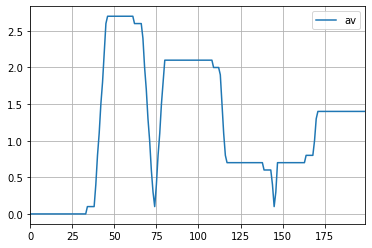

In [4]:
from pandas import DataFrame
DataFrame(log)[["av"]].plot(grid=True)

**Eg.2** Create ten random agents

In [2]:
from scenario import *
from random import random

scen = Scenario()
n=10
class Agent(Cube):
    def on_step(self,dt):
        self.local_velocity=Vector3.Rand(x=[0,4])
        self.local_angular_velocity=Rotation.Eular(z=random()-0.5)
for i in range(n):
    cube=Agent()
    cube.position=Vector3(0,0,0.5)
    scen.add(cube)
scen.paused=True
scen.render()
def run(scen):
    while scen.t<10:
        scen.step(0.1)
        scen.render()
        sleep(0.1)
sim=threading.Thread(target=run,args=(scen,))
sim.start()

**Eg.3** An agent follow a random agent

In [4]:
from scenario import *
from time import sleep
from random import random
scen = Scenario()
cube=Cube()
cube.scale=Vector3(2,1,1)
cube.position=Vector3(3,3,0.5)
cube.color=Color(r=1)
cube.rotation=Rotation.Eular(z=0.3)
cube1=Cube()
cube1.scale=Vector3(2,1,1)
cube1.position=Vector3(0,0,0.5)
cube1.color=Color(b=1)
scen.add(cube,cube1)
scen.render()

while scen.t<10:
    cube.local_velocity=Vector3.Rand(x=[0,2])
    cube.local_angular_velocity=Rotation.Eular(z=random()-0.3)
    cube1.local_velocity=Vector3(x=1)
    cube1.lookat(cube.position)
    scen.step(0.1)
    scen.render()
    sleep(0.1)

**Eg.4** An random agent and following agents, one by one.

In [5]:
from scenario import *

class Follower(Cube):
    def __init__(self):
        Cube.__init__(self)
        self.scale=Vector3(2,1,1)
        self.front=None
    def on_step(self,dt):
        if self.front:
            d=(self.front.position-self.position).norm()
            self.local_velocity=Vector3(x=d*0.1)
            self.lookat(self.front.position)
        else:
            self.local_velocity=Vector3.Rand(x=[0,2])
            self.local_angular_velocity=Rotation.Eular(z=0.1)
scen = Scenario()
n=10
front=None
for i in range(n):
    f=Follower()
    f.position=Vector3(10,0,0.5)-i*Vector3(3,0,0)
    if front:
        f.front=front
    scen.add(f)
    front=f
def run(scen):
    while scen.t<15:
        scen.step(0.1)
        scen.render()
        sleep(0.1)
sim=threading.Thread(target=run,args=(scen,))
sim.start()

## Traffic

### Eg.1
A long straight road which has two lanes. There are two cars on this road. One is red, and another is blue and follows the red one. The red car's speed decreases from 7m/s, while the blue car run fast as possible until reach safe distance between those two cars. 

In [6]:
from scenario import *

scen=Scenario()
left_edge=Line()
left_edge.add_point([-50,-3,0],[50,-3,0])
left_edge.color=Color(b=1)
left_edge.width=2
right_edge=Line()
right_edge.add_point([-50,3,0],[50,3,0])
right_edge.color=Color(b=1)
right_edge.width=2
scen.add(left_edge,right_edge)

class Agent(Cube):
    def __init__(self,color):
        Cube.__init__(self,4,1.8,1.48)
        self.color=color
        self.front=None
        self.local_velocity=Vector3()
        self.log=[]
        
    def on_step(self,dt):
        if self.front:
            safe_distance=self.local_velocity.norm().item()**2/9+6
            d=(self.front.position-self.position).norm().item()
            self.local_velocity=Vector3(x=0.5*(d-safe_distance))
            self.log.append(dict(sd=safe_distance,d=d,lv=self.local_velocity[0].item()))
        else:
#             self.local_velocity=Vector3(x=max(7-scen.t,0))
            self.local_velocity=Vector3(x=7)
        
red=Agent(Color(r=1))
red.position=Vector3(-30,-1.5,0.74)

blue=Agent(Color(b=1))
blue.front=red
blue.position=Vector3(-40,-1.5,0.74)

scen.add(red,blue)
# scen.render()
def run(scen):
    while scen.t<20:
        scen.step(0.1)
        scen.render()
        sleep(0.1)
        
sim=threading.Thread(target=run,args=(scen,))
sim.start()

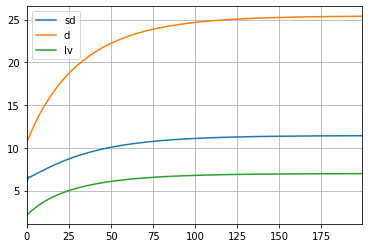

In [8]:
%matplotlib inline
from pandas import DataFrame
log=DataFrame(blue.log)
log[["sd","d","lv"]].plot(grid=True)

### Eg.2
Still those two cars. Change the rule that the red car's speed follows. Set its speed to a constant value.

$d_{target}=5m$

$d_{real}\uparrow v_{blue}\uparrow$

$v_{blue}$ should decrease before $d_{real}=d_{target}$

When $v_{blue}=v_{red}$ and $d_{real}=d_{target}$, the system enter stable state.

In [16]:
from scenario import *

scen=Scenario()
left_edge=Line()
left_edge.add_point([-50,-3,0],[50,-3,0])
left_edge.color=Color(b=1)
left_edge.width=2
right_edge=Line()
right_edge.add_point([-50,3,0],[50,3,0])
right_edge.color=Color(b=1)
right_edge.width=2
scen.add(left_edge,right_edge)

class Agent(Cube):
    def __init__(self,color):
        Cube.__init__(self,4,1.8,1.48)
        self.color=color
        self.front=None
        self.local_velocity=Vector3()
        self.log=[]
        self.pid=PID(1.2,0.4,0)
        
    def on_step(self,dt):
        if self.front:
            safe_distance=self.velocity.norm().item()**2/9+6
            d=(self.front.position-self.position)[0].item()
            err=d-safe_distance
            self.local_velocity=Vector3(max(self.local_velocity[0]+self.pid.step(err,dt),0),0,0)
            self.log.append(dict(sd=safe_distance,d=d,err=err,lv=self.local_velocity[0].item(),v=self.velocity[0].item()))
        else:
#             self.local_velocity=Vector3(x=max(7.5-scen.t,0))
            self.local_velocity=Vector3(x=3*sin(scen.t)+3)
        
red=Agent(Color(r=1))
red.position=Vector3(-30,-1.5,0.74)

blue=Agent(Color(b=1))
blue.front=red
blue.position=Vector3(-40,-1.5,0.74)

scen.add(red,blue)
scen.render()
def run(scen):
    while scen.t<10:
        scen.step(0.1)
        sleep(0.1)
        scen.render()
sim=threading.Thread(target=run,args=(scen,))
sim.start()

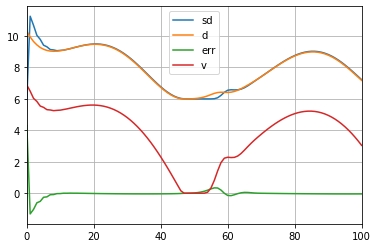

In [24]:
%matplotlib inline
from pandas import *
log=DataFrame(blue.log)
log[["sd","d","err","v"]].plot(grid=True)

In [27]:
from scenario import *
from pandas import *
scen=Scenario()
left_edge=Line()
left_edge.add_point([-50,-3,0],[50,-3,0])
left_edge.color=Color(b=1)
left_edge.width=2
right_edge=Line()
right_edge.add_point([-50,3,0],[50,3,0])
right_edge.color=Color(b=1)
right_edge.width=2
scen.add(left_edge,right_edge)

class Agent(Cube):
    def __init__(self):
        Cube.__init__(self,4,1.8,1.48)
        self.front=None
        self.local_velocity=Vector3()
        self.pid=PID(1.,0.07,0)
        self.log=[]
        
    def on_step(self,dt):
        if self.front:
            safe_distance=self.velocity.norm().item()**2/9+6
            d=(self.front.position-self.position)[0].item()
            err=d-safe_distance
            dv=self.pid.step(err,dt)
            self.local_velocity=Vector3(max(self.local_velocity[0]+dv,0),0,0)
            self.log.append({"safe distance":safe_distance,
                        "distance":d,
                        "error":err,
                        "dv":dv,
                        "local velocity":self.local_velocity[0].item(),
                        "velocity":self.velocity[0].item()})
        else:
            self.local_velocity=Vector3(x=max(10-scen.t,0))
#             self.local_velocity=Vector3(x=3*sin(scen.t)+3)
            self.log.append({"t":scen.t,
                "local velocity":self.local_velocity[0].item(),
                        "velocity":self.velocity[0].item()})
        
front=None       
for i in range(10):
    a=Agent()
    a.id=i
    a.position=Vector3(-50-10*i,-1.5,0.74)
    a.front=front
    scen.add(a)
    front=a

def run(scen):
    scen.render()
    while scen.t<20:
        scen.step(0.1)
        scen.render()
        sleep(0.1)
        
sim=threading.Thread(target=run,args=(scen,))
sim.start()

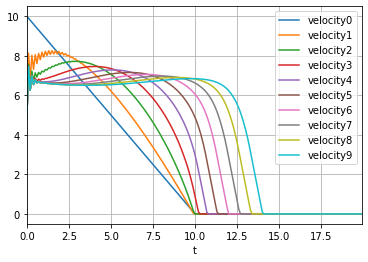

In [11]:
%matplotlib inline
from pandas import *
from IPython import display

dfs=[DataFrame(scen.objects[0].log)[["t"]]]
for i in range(10):
    v=DataFrame(scen.objects[i].log)[["velocity"]]
    v=v.rename(columns={"velocity":"velocity"+str(i)})
    dfs.append(v)
concat(dfs,axis=1).plot(x="t",grid=True)

In [26]:
from IPython import display
import matplotlib.pyplot as plt
fig=plt.figure()
while scen.t<20:
    sleep(1)
    display.clear_output(wait=True)
    plt.clf()
    plt.grid()
    plt.plot(DataFrame(scen.objects[1].log)[["velocity"]])
    display.display(fig)

<Figure size 432x288 with 0 Axes>

### Eg.4
**Path Tracking**. A blue car tracks a given path. 

In [1]:
from scenario import *
from time import sleep
path=Line()
path.color=Color(g=0.3)
x=torch.linspace(-1.5,1.5)
y=torch.tan(x)
path.points=torch.empty(len(x),3)
path.points[:,0]=x
path.points[:,1]=y
path.points[:,2]=0.5
scen=Scenario()
scen.add(path)
car=Cube()
car.color=Color(b=0.8)
car.direction=Vector3(0,1,0)
car.position=path.points[0]+Vector3(0,0,0.5)
scen.add(car)
car.add(Line.Vector(car.direction))
for p in path.points:
    car.lookat(p)
    car.position=p
    scen.render()
    sleep(0.1)

### Eg.4

The red car do not move. The blue car change lane. After action, the blue car's rotation do not change, but position is forward and offset to left lane. Local velocity of the blue car do not change during the process.

In [7]:
from scenario import *
import matplotlib.pyplot as plt

scen=Scenario()
left_edge=Line()
left_edge.add_point([-50,-3,0],[50,-3,0])
left_edge.color=Color(b=1)
left_edge.width=2
right_edge=Line()
right_edge.add_point([-50,3,0],[50,3,0])
right_edge.color=Color(b=1)
right_edge.width=2
scen.add(left_edge,right_edge)

class Agent(Cube):
    def __init__(self,color):
        Cube.__init__(self,4,1.8,1.48)
        self.color=color
        self.front=None
        self.pid=PID(0.02,0.0,0.0)
        self.log=[]
        
    def on_step(self,dt):
        if self.front:
            self.turn_left(dt)
            self.local_velocity=Vector3(2,0,0)
        
    def turn_left(self,dt):
        r=self.rotation.to_eular()[2]
        d=0.75-self.position[1]
        err=d
        av=self.pid.step(err,dt)
        self.local_angular_velocity=Rotation.Eular(0,0,av)
        self.log.append({"t":scen.t,"yaw":r,"y distance":d,"error":err,"angular velocity":av})
        if abs(d)<0.1 and abs(r)<0.1:
            self.turning=False
            self.local_angular_velocity=Rotation()
        
red=Agent(Color(r=1))
red.position=Vector3(-30,-1.5,0.74)
blue=Agent(Color(b=1))
blue.front=red
blue.position=Vector3(-40,-1.5,0.74)

blue.add(Line.Vector(4*blue.direction))
path=Line()
scen.add(red,blue,path)
def onkey(key):
    print(key)
scen.on_key=onkey
scen.render()
def run(scen):
    while scen.t<40:
        scen.step(0.1)
        path.add_point(blue.position)
        sleep(0.1)
        scen.render()
sim=threading.Thread(target=run,args=(scen,))
sim.start()

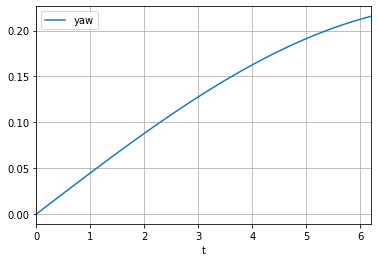

In [29]:
%matplotlib inline
from pandas import *
log=DataFrame(blue.log)
log[["t","yaw"]].plot(x="t",y="yaw",grid=True)

### Eg.5

In [7]:
from scenario import *
l=Line()
l.color=Color(r=1)
x=torch.linspace(0,100,10)
l.points=torch.zeros(len(x),3)
l.points[:,0]=x
l.points[:,1]=4
l.points[1]=0.7*l.points[2]+0.3*Vector3()
l.points[2]=0.7*l.points[3]+0.3*l.points[1]
s1=Sphere(0.2)
s1.position=l.points[1]
s2=Sphere(0.2)
s2.position=l.points[2]
scen=Scenario()
scen.add(l,s1,s2)
scen.render()

# RL agent

An agent who's local velocity is constant but local angular velocity is controlled by a neural network.

In [8]:
from scenario import *
import matplotlib.pyplot as plt

scen=Scenario()
left_edge=Line()
left_edge.add_point([-50,-3,0],[50,-3,0])
left_edge.color=Color(b=1)
left_edge.width=2
right_edge=Line()
right_edge.add_point([-50,3,0],[50,3,0])
right_edge.color=Color(b=1)
right_edge.width=2
scen.add(left_edge,right_edge)
red=Cube(4,1.8,1.48)
red.color=Color(r=1)
red.position=Vector3(-30,-1.5,0.74)
class Agent(Cube):
    def __init__(self):
        Cube.__init__(self,4,1.8,1.48)
        self.color=Color(b=1)
        self.position=Vector3(-40,-1.5,0.74)
        self.local_velocity=Vector3(x=2)
        self.add(Line.Vector(4*self.direction))
        self.nn=NN(2,1)
        self.log=[]
        
    def on_step(self,dt):
        observation=(red.position-self.position)[0:2]
        self.local_angular_velocity=Rotation.Eular(z=self.nn(observation))
        

blue=Agent()
path=Line()
scen.add(red,blue,path)
scen.render()
def run(scen):
    while scen.t<20:
        scen.step(0.1)
        path.add_point(blue.position)
        sleep(0.1)
        scen.render()
sim=threading.Thread(target=run,args=(scen,))
sim.start()

In [9]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig=plt.figure()
plt.title("nn")
ax = fig.add_subplot(111, projection='3d')
xy=torch.combinations(torch.linspace(-10,10,21),r=2)
z=blue.nn(xy).cpu().detach()
ax.scatter(xs=xy[:,0],ys=xy[:,1],zs=z)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/hjj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


Agent controlled by a neural network with a normal distribution layer

In [62]:
from scenario import *
import matplotlib.pyplot as plt
log=[]
class Agent(Cube):
    def __init__(self):
        Cube.__init__(self,4,1.8,1.48)
        self.color=Color(b=1)
        self.position=Vector3(-40,-1.5,0.74)
        self.local_velocity=Vector3(x=2)
        self.add(Line.Vector(4*self.direction))
        self.nn=NN(2,2)
        self.loss=0
        self.front=None
        self.pre_x=None

    def on_step(self,dt):
        observation=(self.front.position-self.position)[0:2]
        dx=self.position[0].item()-self.pre_x if self.pre_x is not None else 0
        self.pre_x=self.position[0].item()
        out=self.nn(observation)
        action=torch.normal(mean=out[0],std=out[1])
        reward=dx-abs(over(self.position[1].item(),-3,3))
        self.loss+=reward
        log.append({"mean":out[0].item(),"std":out[1].item(),"action":action.item(),"x":self.position[0].item(),"y":self.position[1].item(),"reward":reward})
        self.local_angular_velocity=Rotation.Eular(z=action)
scen=Scenario()     
def episode(scen):
    scen.reset()
    left_edge=Line()
    left_edge.add_point([-50,-3,0],[50,-3,0])
    left_edge.color=Color(b=1)
    left_edge.width=2
    right_edge=Line()
    right_edge.add_point([-50,3,0],[50,3,0])
    right_edge.color=Color(b=1)
    right_edge.width=2
    scen.add(left_edge,right_edge)
    red=Cube(4,1.8,1.48)
    red.color=Color(r=1)
    red.position=Vector3(-30,-1.5,0.74)

    blue=Agent()
    blue.front=red
    path=Line()
    scen.add(red,blue,path)
    scen.render()
    for i in range(100):
        scen.step(0.1)
        path.add_point(blue.position)
        sleep(0.1)
        scen.render()

def cycle(scen):
    for i in range(10):
        episode(scen)
        print(i)
        sleep(1)
sim=threading.Thread(target=cycle,args=(scen,))
sim.start()

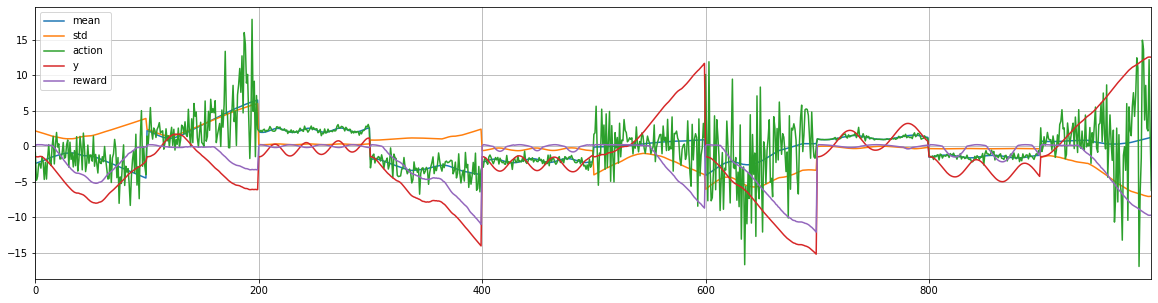

In [65]:
from pandas import DataFrame
l=DataFrame(log)
l[["mean","std","action","y","reward"]].plot(grid=True,figsize=(20,5))

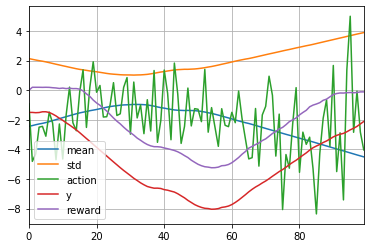

In [71]:
l[["mean","std","action","y","reward"]][0:100].plot(grid=True)

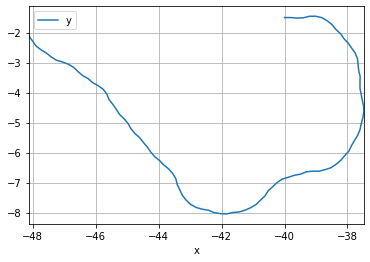

In [72]:
l[["x","y"]][0:100].plot(grid=True,x="x",y="y")

The loss has no relationship with policy the agent follow. So there is no way to train the neural network.

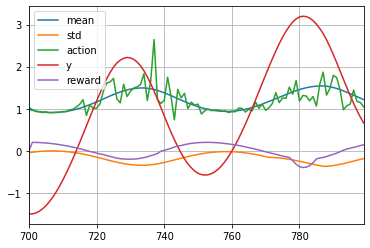

In [66]:
l[["mean","std","action","y","reward"]][700:800].plot(grid=True)

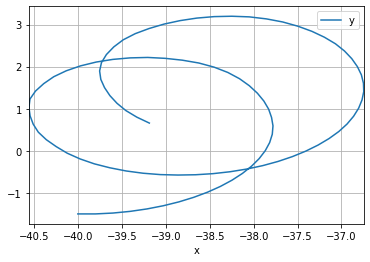

In [69]:
l[["mean","std","action","x","y","reward"]][700:800].plot(grid=True,x="x",y="y")